In [ ]:
# Install the relevant packages.

!pip install matplotlib==3.8.4
!pip install torch==2.2.2
!pip install torchvision==0.17.0
!pip install scikit-learn==1.4.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 51.3 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 500.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 52.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 49.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 457.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
pip install cuda-quantum

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.8/105.8 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.9/38.9 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.1/142.1 MB 6.3 MB/s eta 0:00:00


In [ ]:
import cudaq
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Function
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [ ]:
# Set CUDAQ and PyTorch to run on either CPU or GPU
device = torch.device('cpu')
cudaq.set_target("qpp-cpu")

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Define quantum operations
def ry(theta, qubit):
    # Define the rotation about the Y-axis
    cudaq.ry(theta, qubit)

def rx(theta, qubit):
    # Define the rotation about the X-axis
    cudaq.rx(theta, qubit)

In [ ]:
# Define the Quantum Function
class QuantumFunction(Function):
    def __init__(self, qubit_count: int, hamiltonian: cudaq.SpinOperator):
        @cudaq.kernel
        def kernel(qubit_count: int, thetas: np.ndarray):
            qubits = cudaq.qvector(qubit_count)
            ry(thetas[0], qubits[0])
            rx(thetas[1], qubits[0])
        self.kernel = kernel
        self.qubit_count = qubit_count
        self.hamiltonian = hamiltonian

    def run(self, theta_vals: torch.Tensor) -> torch.Tensor:
        # Ensure theta_vals is converted to numpy array for quantum circuit
        theta_vals_np = theta_vals.cpu().numpy()
        qubit_count = [self.qubit_count for _ in range(theta_vals_np.shape[0])]
        results = cudaq.observe(self.kernel, self.hamiltonian, qubit_count, theta_vals_np)
        exp_vals = [results[i].expectation() for i in range(len(results))]
        return torch.Tensor(exp_vals).to(device)

    @staticmethod
    def forward(ctx, thetas: torch.Tensor, quantum_circuit, shift) -> torch.Tensor:
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit
        exp_vals = ctx.quantum_circuit.run(thetas).reshape(-1, 1)
        ctx.save_for_backward(thetas, exp_vals)
        return exp_vals

    @staticmethod
    def backward(ctx, grad_output):
        thetas, _ = ctx.saved_tensors
        gradients = torch.zeros(thetas.shape, device=device)
        for i in range(thetas.shape[1]):
            thetas_plus = thetas.clone()
            thetas_plus[:, i] += ctx.shift
            exp_vals_plus = ctx.quantum_circuit.run(thetas_plus)
            thetas_minus = thetas.clone()
            thetas_minus[:, i] -= ctx.shift
            exp_vals_minus = ctx.quantum_circuit.run(thetas_minus)
            gradients[:, i] = (exp_vals_plus - exp_vals_minus) / (2 * ctx.shift)
        return gradients * grad_output, None, None

# Define Quantum Layer
class QuantumLayer(nn.Module):
    def __init__(self, qubit_count: int, hamiltonian, shift: torch.Tensor):
        super(QuantumLayer, self).__init__()
        self.quantum_circuit = QuantumFunction(qubit_count, hamiltonian)
        self.shift = shift

    def forward(self, input: torch.Tensor):
        return QuantumFunction.apply(input, self.quantum_circuit, self.shift)

# Define Hybrid Quantum Neural Network
class Hybrid_QNN(nn.Module):
    def __init__(self):
        super(Hybrid_QNN, self).__init__()
        self.fc1 = nn.Linear(len(features), 256)
        self.fc2 = nn.Linear(256, 128)
        self.dropout = nn.Dropout(0.25)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 2)
        self.dropout = nn.Dropout(0.25)
        self.quantum = QuantumLayer(qubit_count=2, hamiltonian=cudaq.spin.z(0), shift=torch.tensor(torch.pi / 2))

    def forward(self, x: torch.Tensor):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = self.dropout(x)
        return torch.sigmoid(self.quantum(x)).view(-1)

In [ ]:
# Load dataset
def load_data(path):
    data = pd.read_csv(path)
    return data
dataset_path = "/content/typeII_AGN_metadata.csv"
data = load_data(dataset_path)

In [ ]:
# Handle missing values by filling with the mean of the column
data.fillna(data.mean(), inplace=True)

In [ ]:
# Prepare features and target
features = [
    'h_beta_flux', 'h_beta_flux_err', 'oiii_5007_flux', 'oiii_5007_flux_err',
    'h_alpha_flux', 'h_alpha_flux_err', 'nii_6584_flux', 'nii_6584_flux_err',
    'log_stellar_sigma', 'psfMag_u', 'psfMag_g', 'psfMag_r', 'psfMag_i',
    'psfMag_z', 'psfMagErr_u', 'psfMagErr_g', 'psfMagErr_r', 'psfMagErr_i',
    'psfMagErr_z', 'mendel_logM_p50', 'mendel_logM_p16', 'mendel_logM_p84',
    'mendel_logMt_p50', 'mendel_logMt_p16', 'mendel_logMt_p84', 'mendel_logMb_p50',
    'mendel_logMb_p16', 'mendel_logMb_p84', 'mendel_logMd_p50', 'mendel_logMd_p16',
    'mendel_logMd_p84', 'simard_b_t_g', 'simard_e_b_t_g', 'simard_b_t_r',
    'simard_e_b_t_r', 'simard_Rhlg', 'simard_Rhlr', 'simard_Rchl_g', 'simard_Rchl_r',
    'simard_Re', 'simard_e_Re', 'simard_e', 'simard_e_e', 'simard_nb',
    'simard_e_nb', 'simard_PpS', 'simard_Pn4'
]

target = 'log_bh_mass'

X = data[features].values
y = data[target].values

In [ ]:
# 4. Normalize the features

# Initialize the scaler
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Normalize X and y
X = scaler_X.fit_transform(X)
y = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

In [ ]:
# Convert to torch tensors
X = torch.tensor(X, dtype=torch.float32).to(device)
y = torch.tensor(y, dtype=torch.float32).to(device)

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Training
model = Hybrid_QNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.MSELoss().to(device)

epochs = 800
losses = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    y_hat_train = model(X_train)
    loss = loss_function(y_hat_train, y_train)
    loss.backward()
    optimizer.step()

    # Store the loss
    losses.append(loss.item())

    # Calculate and print the current epoch, loss, and standard deviation of losses
    std_loss = np.std(losses)
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}, Std Dev: {std_loss}")

# Evaluation
model.eval()
with torch.no_grad():
    y_hat_test = model(X_test)
    test_loss = loss_function(y_hat_test, y_test).item()

    r2_score_value = -r2_score(y_test.cpu(), y_hat_test.cpu())
    mae_score_value = mean_absolute_error(y_test.cpu(), y_hat_test.cpu())
    rmse_score_value = np.sqrt(mean_squared_error(y_test.cpu(), y_hat_test.cpu()))
    mse_score_value = mean_squared_error(y_test.cpu(), y_hat_test.cpu())

Epoch 1/800, Loss: 1.534818172454834, Std Dev: 0.0
Epoch 2/800, Loss: 1.533292293548584, Std Dev: 0.000762939453125
Epoch 3/800, Loss: 1.5310633182525635, Std Dev: 0.0015418447604201957
Epoch 4/800, Loss: 1.5284020900726318, Std Dev: 0.0024181333966537912
Epoch 5/800, Loss: 1.5247104167938232, Std Dev: 0.0035964485129790424
Epoch 6/800, Loss: 1.519359827041626, Std Dev: 0.005280462289018804
Epoch 7/800, Loss: 1.513153076171875, Std Dev: 0.007290149490262618
Epoch 8/800, Loss: 1.501259446144104, Std Dev: 0.010753257707507718
Epoch 9/800, Loss: 1.485920786857605, Std Dev: 0.015506941242183445
Epoch 10/800, Loss: 1.465240716934204, Std Dev: 0.021853564526893837
Epoch 11/800, Loss: 1.4410146474838257, Std Dev: 0.0295135804511722
Epoch 12/800, Loss: 1.4075748920440674, Std Dev: 0.039437304245695984
Epoch 13/800, Loss: 1.3660502433776855, Std Dev: 0.05183911159272906
Epoch 14/800, Loss: 1.3239635229110718, Std Dev: 0.06552279369067202
Epoch 15/800, Loss: 1.2888062000274658, Std Dev: 0.078785

In [ ]:
y_max = torch.max(y.cpu()).item()
y_min = torch.min(y.cpu()).item()
alpha = y_max - y_min

# Accuracy by error
mae_accuracy = (1 - mae_score_value / alpha ) * 100
rmse_accuracy = (1 - rmse_score_value / alpha) * 100
mse_accuracy = (1 - mse_score_value / alpha) * 100

# Calculate standard deviations based on test set
mae_std = np.std([mean_absolute_error(y_test.cpu(), model(X_test).cpu().detach().numpy()) for _ in range(epochs)])
rmse_std = np.std([np.sqrt(mean_squared_error(y_test.cpu(), model(X_test).cpu().detach().numpy())) for _ in range(epochs)])
mse_std = np.std([mean_squared_error(y_test.cpu(), model(X_test).cpu().detach().numpy()) for _ in range(epochs)])

print(f"R^2 Score: {-r2_score_value}")
print(f"MAE: {mae_score_value}")
print(f"RMSE: {rmse_score_value}, Accuracy by error: {rmse_accuracy}%, Std Dev: ±{rmse_std}")
print(f"MSE: {mse_score_value}, Accuracy by error: {mse_accuracy}%, Std Dev: ±{mse_std}")

R^2 Score: 0.017728232785241937
MAE: 0.7584974765777588
RMSE: 0.9992857575416565, Accuracy by error: 87.38510028965484%, Std Dev: ±0.0
MSE: 0.998572051525116, Accuracy by error: 87.39411005463286%, Std Dev: ±5.960464477539063e-08


In [ ]:
print("Accuracy by Error: MAE is :",mae_accuracy,"%")

Accuracy by Error: MAE is : 90.42479138187913 %


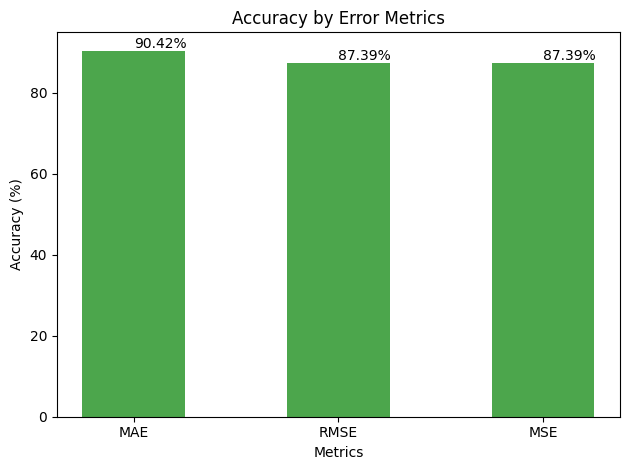

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data
metrics = ['MAE', 'RMSE', 'MSE']
accuracies = [90.42479138187913, 87.38510028965484, 87.39411005463286]

# Plotting
fig, ax = plt.subplots()

# Create bar chart
index = np.arange(len(metrics))
bar_width = 0.5

bars = ax.bar(index, accuracies, bar_width, color='g', alpha=0.7)

# Labels and title
ax.set_xlabel('Metrics')
ax.set_ylabel('Accuracy (%)')
ax.set_xticks(index)
ax.set_xticklabels(metrics)
ax.set_title('Accuracy by Error Metrics')

# Adding value labels on bars
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}%', va='bottom')

plt.tight_layout()

# Show plot
plt.show()
